<center><img src="https://raw.githubusercontent.com/jmsr06/retinopatiaDiabetica/master/retinopatia2.jpg" tite="Inteligencia Artificial en la medicina" style="width:1000px" alt="Algoritmos de Machine learning y Deep learning para la predicción de la realización biopsia"/>


<table align="left" border="1" style="font-size:100px">
<th>Nombre</th>
<th>Código</th>
<tr>
</tr>
<tr> 
<td>Jenny Marcela Santamaría</td>
<td>2171455</td>
</tr>
<tr>
<td>Nelson Alexis Cáceres</td>
<td>2171763</td>
</tr>
</table>


In [1]:
#@title  MONTAR EL DRIVE
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/IAII')

Mounted at /content/drive


In [2]:
pip install -q pyyaml h5py

In [3]:
pip install tensorflow-addons

     |████████████████████████████████| 706kB 9.0MB/s 


In [4]:
#@title Load libraries { display-mode: "form" }
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import warnings
import os,shutil
warnings.filterwarnings("ignore")
from sklearn.metrics import *
import tensorflow_addons as tfa

#**Detección de retinopatía diabética**

La retinopatía diabética es la principal causa de ceguera en la población del mundo y se estima que afecta a más de 93 millones de personas. Hace tiempo se reconoce la necesidad de un método automatizado para la detección de esta enfermedad ocular ya que actualmente se realiza mediante un proceso manual y requiere de mucho tiempo, a su vez, de un médico capacitado que examine y evalúe fotografías digitales de la retina, por ello se plantea resolver este problema mediante deep learning por medio de algoritmos que permitan clasificar dichas imágenes y por ende automatizar este procedimiento.

Cabe resaltar que la retinopatía diabética no tiene cura, sin embargo lo que se busca es realizar un tratamiento a tiempo que retrace la pérdida de visión a causa de esta condición.

##Importar los datos

El conjunto de datos consta de 35.126 imágenes de escaneo de retina tomadas en un exámen de fondo de ojo, tanto del ojo izquierdo como del derecho. Dichas imágenes se categorizan dependiendo el estado o etapa en la cual se encuentra esta enfermedad ocular:

*   **0-Sin retinopatía diabética:** 25.810 imágenes
*   **1-Leve:** 2.443 imágenes
*   **2-Moderada:** 5.292 imágenes
*   **3-Grave:** 873 imágenes
*   **4-Retinopatía diabética proliferativa:** 708 imágenes



Para tranformar el conjunto de datos de train y test, se usa la función ImageDataGenerator, la única transformación que se utiliza para los datos de train es reflejar las imágenes de este conjunto de datos. Para los datos de test y validación las imágenes no se transforman.

Text(0.5, 1.0, 'RD proliferativo')

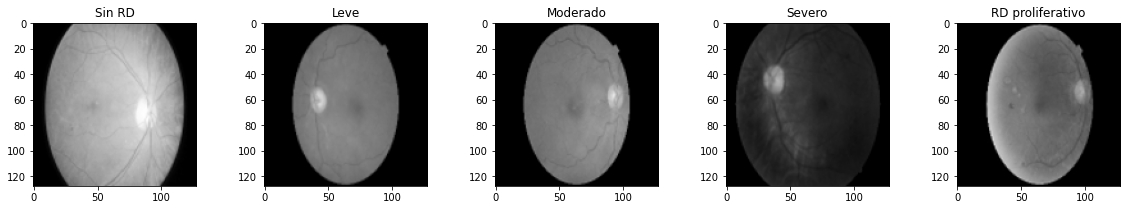

In [ ]:
#@title Fases de la Retinopatía diabética 
No_DR = plt.imread("./resize/train/No_DR/41_left.png")
Leve = plt.imread("resize/train/Mild/15_left.png")
Moderado = plt.imread("resize/train/Moderate/15_right.png")
Severo = plt.imread("resize/train/Severe/99_left.png")
RD_proliferativo = plt.imread("resize/train/Proliferate_DR/217_right.png")

plt.figure(figsize=(20,3))
plt.subplot(1,5,1)
plt.imshow(No_DR)
plt.title("Sin RD")
plt.subplot(1,5,2)
plt.imshow(Leve)
plt.title("Leve")
plt.subplot(1,5,3)
plt.imshow(Moderado)
plt.title("Moderado")
plt.subplot(1,5,4)
plt.imshow(Severo)
plt.title("Severo")
plt.subplot(1,5,5)
plt.imshow(RD_proliferativo)
plt.title("RD proliferativo")

In [ ]:
data = pd.read_csv('trainLabels.csv')
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
#@title modificación del dataset
base_image_dir = ['resize/No_DR','resize/Mild','resize/Moderate','resize/Severe','resize/Proliferate_DR']

di0 = data[data['level']==0].image.map(lambda x: os.path.join(base_image_dir[0],'{}.png'.format(x)))
di1 = data[data['level']==1].image.map(lambda x: os.path.join(base_image_dir[1],'{}.png'.format(x)))
di2 = data[data['level']==2].image.map(lambda x: os.path.join(base_image_dir[2],'{}.png'.format(x)))
di3 = data[data['level']==3].image.map(lambda x: os.path.join(base_image_dir[3],'{}.png'.format(x)))
di4 = data[data['level']==4].image.map(lambda x: os.path.join(base_image_dir[4],'{}.png'.format(x)))
data['path'] = pd.concat([di0,di1,di2,di3,di4])
data['exists'] = data['path'].map(os.path.exists)

data = data[data['exists']]
data = data.drop(columns=['image','exists'])
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,level,path
0,2,resize/Moderate/36793_right.png
1,0,resize/No_DR/2169_right.png
2,0,resize/No_DR/14998_left.png
3,1,resize/Mild/34340_right.png
4,0,resize/No_DR/38791_left.png


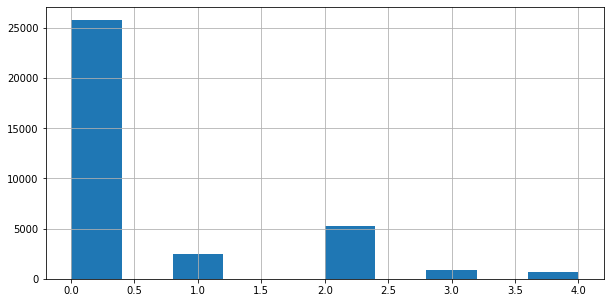

In [ ]:
#@title distribución de los datos
data['level'].hist(figsize = (10, 5))

In [ ]:
nodr=np.array(os.listdir('resize/No_DR'))
mild=np.array(os.listdir('resize/Mild'))
moderate=np.array(os.listdir('resize/Moderate'))
severe=np.array(os.listdir('resize/Severe'))
proliferate=np.array(os.listdir('resize/Proliferate_DR'))

In [ ]:
#@title Vector de transformaciones
transformaciones=['cut', 'flip_horizontal','cut_flip']
transformaciones=np.array(transformaciones)
transformaciones

array(['cut', 'flip_horizontal', 'cut_flip'], dtype='<U15')

In [ ]:
#@title Función nombres aleatorios
letter = string.ascii_letters + '0123456789_'
def random_char(y):
  return ''.join(random.choice(letter) for x in range(y))
print(random_char(10))

2C4N2yANDA


In [ ]:
#@title Data augmentation 'Proliferate_DR'
import string
import random
os.mkdir('resize/train/gtrain/Proliferate_DR')
tam = mild.shape[0] - proliferate.shape[0]
for i in range(tam):
  img = np.random.randint(proliferate.shape[0])
  indice = np.random.randint(transformaciones.shape[0])
  #transf = transformaciones[indice]
  image=imageio.imread('resize/Proliferate_DR/'+proliferate[img])
  if indice==0:
    im2=tf.image.central_crop(image, 0.95)
    im2=resize(im2, (128,128,4))
  if indice==1:
    im2=tf.image.flip_left_right(image)
  if indice==2:
    im2=tf.image.central_crop(image, 0.95)
    im2=resize(im2, (128,128,4))
    im2=tf.image.flip_left_right(im2)
  savepath = 'resize/train/gtrain/Proliferate_DR/'+random_char(20) + proliferate[img] +'.png'
  imageio.imsave(savepath,np.array(im2))
  tam=tam-1

In [ ]:
#@title Data augmentation 'Severe'
os.mkdir('resize/train/gtrain/Severe')
tam = mild.shape[0] - severe.shape[0]
for i in range(tam):
  img = np.random.randint(severe.shape[0])
  indice = np.random.randint(transformaciones.shape[0])
  #transf = transformaciones[indice]
  image=imageio.imread('resize/Severe/'+severe[img])
  if indice==0:
    im2=tf.image.central_crop(image, 0.95)
    im2=resize(im2, (128,128,4))
  if indice==1:
    im2=tf.image.flip_left_right(image)
  if indice==2:
    im2=tf.image.central_crop(image, 0.95)
    im2=resize(im2, (128,128,4))
    im2=tf.image.flip_left_right(im2)
  savepath = 'resize/train/gtrain/Severe/'+random_char(20) + severe[img] +'.png'
  imageio.imsave(savepath,np.array(im2))
  tam=tam-1

In [ ]:
#@title crear carpetas para train y test (no correr)
os.mkdir('resize/train/No_DR')
os.mkdir('resize/train/Mild')
os.mkdir('resize/train/Moderate')
os.mkdir('resize/train/Severe')
os.mkdir('resize/train/Proliferate_DR')
os.mkdir('resize/test/No_DR')
os.mkdir('resize/test/Mild')
os.mkdir('resize/test/Moderate')
os.mkdir('resize/test/Severe')
os.mkdir('resize/test/Proliferate_DR')

In [ ]:
#@title Mover imágenes de Test (no correr)
ruta = os.getcwd() + os.sep
#Mild
index = os.listdir('resize/Mild')
np.random.shuffle(index)
for i in index[:200]:
  origen = ruta + 'resize/Mild/' + i
  destino = ruta + 'resize/test/Mild/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#Moderate
index = os.listdir('resize/Moderate')
np.random.shuffle(index)
for i in index[:200]:
  origen = ruta + 'resize/Moderate/' + i
  destino = ruta + 'resize/test/Moderate/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#No_DR
index = os.listdir('resize/No_DR')
np.random.shuffle(index)
for i in index[:200]:
  origen = ruta + 'resize/No_DR/' + i
  destino = ruta + 'resize/test/No_DR/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#Severe
index = os.listdir('resize/Severe')
np.random.shuffle(index)
for i in index[:200]:
  origen = ruta + 'resize/Severe/' + i
  destino = ruta + 'resize/test/Severe/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#Proliferate_DR
index = os.listdir('resize/Proliferate_DR')
np.random.shuffle(index)
for i in index[:200]:
  origen = ruta + 'resize/Proliferate_DR/' + i
  destino = ruta + 'resize/test/Proliferate_DR/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')

In [ ]:
#@title Mover imágenes de Train (no correr)
ruta = os.getcwd() + os.sep
#Mild
index = os.listdir('resize/Mild')
np.random.shuffle(index)
for i in index[:2438]:
  origen = ruta + 'resize/Mild/' + i
  destino = ruta + 'resize/train/Mild/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#Moderate
index = os.listdir('resize/Moderate')
np.random.shuffle(index)
for i in index[:2438]:
  origen = ruta + 'resize/Moderate/' + i
  destino = ruta + 'resize/train/Moderate/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else: 
    print('El archivo origen no existe')
#No_DR
index = os.listdir('resize/No_DR')
np.random.shuffle(index)
for i in index[:2438]:
  origen = ruta + 'resize/No_DR/' + i
  destino = ruta + 'resize/train/No_DR/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#Severe
index = os.listdir('resize/Severe')
np.random.shuffle(index)
for i in index[:]:
  origen = ruta + 'resize/Severe/' + i
  destino = ruta + 'resize/train/Severe/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#Severe creadas
index = os.listdir('resize/train/gtrain/Severe')
np.random.shuffle(index)
for i in index:
  origen = ruta + 'resize/train/gtrain/Severe/' + i
  destino = ruta + 'resize/train/Severe/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#Proliferate_DR
index = os.listdir('resize/Proliferate_DR')
np.random.shuffle(index)
for i in index[:]:
  origen = ruta + 'resize/Proliferate_DR/' + i
  destino = ruta + 'resize/train/Proliferate_DR/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')
#Proliferate_DR creadas
index = os.listdir('resize/train/gtrain/Proliferate_DR')
np.random.shuffle(index)
for i in index[:]:
  origen = ruta + 'resize/train/gtrain/Proliferate_DR/' + i
  destino = ruta + 'resize/train/Proliferate_DR/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')

In [ ]:
#@title Creación dataset Train
#path1 = os.listdir('resize/train/Mild')
#level1 = [1 for i in path1]
#
#path0 = os.listdir('resize/train/No_DR')
#level0 = [0 for i in path0]
#
#path2 = os.listdir('resize/train/Moderate')
#level2 = [2 for i in path2]
#
#path3 = os.listdir('resize/train/Severe')
#level3 = [3 for i in path3]
#
#path4 = os.listdir('resize/train/Proliferate_DR')
#level4 = [4 for i in path4]
#
#path = np.concatenate((path1,path0,path2,path3,path4), axis=0)
#level = np.concatenate((level1,level0,level2,level3,level4), axis=0)
#
#dataset_train = pd.DataFrame({'level' : pd.Series(level),'image' : pd.Series(path) })
#dataset_train.head()
#
#base_image_dir = ['resize/train/No_DR','resize/train/Mild','resize/train/Moderate','resize/train/Severe','resize/train/Proliferate_DR']
#
#di0 = dataset_train[dataset_train['level']==0].image.map(lambda x: os.path.join(base_image_dir[0],'{}'.format(x)))
#di1 = dataset_train[dataset_train['level']==1].image.map(lambda x: os.path.join(base_image_dir[1],'{}'.format(x)))
#di2 = dataset_train[dataset_train['level']==2].image.map(lambda x: os.path.join(base_image_dir[2],'{}'.format(x)))
#di3 = dataset_train[dataset_train['level']==3].image.map(lambda x: os.path.join(base_image_dir[3],'{}'.format(x)))
#di4 = dataset_train[dataset_train['level']==4].image.map(lambda x: os.path.join(base_image_dir[4],'{}'.format(x)))
#dataset_train['path'] = pd.concat([di0,di1,di2,di3,di4])
#dataset_train['exists'] = dataset_train['path'].map(os.path.exists)
#
#dataset_train = dataset_train[dataset_train['exists']]
#dataset_train = dataset_train.drop(columns=['image','exists'])
#dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)
#dataset_train.to_csv('dataset_train.csv')
dataset_train = pd.read_csv('dataset_train.csv', index_col='Unnamed: 0')
dataset_train.head()

,level,path
0,1,resize/train/Mild/1933_left.png
1,3,resize/train/Severe/NJjeCeumJrLiaQBCIQau34442_...
2,2,resize/train/Moderate/26113_right.png
3,4,resize/train/Proliferate_DR/Ph_2uINtR7vFA787cA...
4,0,resize/train/No_DR/20137_left.png


In [ ]:
#@title Creación dataset Test
#path1 = os.listdir('resize/test/Mild')
#level1 = [1 for i in path1]
#
#path0 = os.listdir('resize/test/No_DR')
#level0 = [0 for i in path0]
#
#path2 = os.listdir('resize/test/Moderate')
#level2 = [2 for i in path2]
#
#path3 = os.listdir('resize/test/Severe')
#level3 = [3 for i in path3]
#
#path4 = os.listdir('resize/test/Proliferate_DR')
#level4 = [4 for i in path4]
#
#path = np.concatenate((path1,path0,path2,path3,path4), axis=0)
#level = np.concatenate((level1,level0,level2,level3,level4), axis=0)
#
#dataset_test = pd.DataFrame({'level' : pd.Series(level),'image' : pd.Series(path) })
#dataset_test.head()
#
#base_image_dir = ['resize/test/No_DR','resize/test/Mild','resize/test/Moderate','resize/test/Severe','resize/test/Proliferate_DR']
#
#di0 = dataset_test[dataset_test['level']==0].image.map(lambda x: os.path.join(base_image_dir[0],'{}'.format(x)))
#di1 = dataset_test[dataset_test['level']==1].image.map(lambda x: os.path.join(base_image_dir[1],'{}'.format(x)))
#di2 = dataset_test[dataset_test['level']==2].image.map(lambda x: os.path.join(base_image_dir[2],'{}'.format(x)))
#di3 = dataset_test[dataset_test['level']==3].image.map(lambda x: os.path.join(base_image_dir[3],'{}'.format(x)))
#di4 = dataset_test[dataset_test['level']==4].image.map(lambda x: os.path.join(base_image_dir[4],'{}'.format(x)))
#dataset_test['path'] = pd.concat([di0,di1,di2,di3,di4])
#dataset_test['exists'] = dataset_test['path'].map(os.path.exists)
#
#dataset_test = dataset_test[dataset_test['exists']]
#dataset_test = dataset_test.drop(columns=['image','exists'])
#dataset_test = dataset_test.sample(frac=1).reset_index(drop=True)
#dataset_test.to_csv('dataset_test.csv')
dataset_test = pd.read_csv('dataset_test.csv', index_col='Unnamed: 0')
dataset_test.head()

,level,path
0,0,resize/test/No_DR/41250_left.png
1,4,resize/test/Proliferate_DR/4909_left.png
2,1,resize/test/Mild/12278_right.png
3,0,resize/test/No_DR/37159_right.png
4,2,resize/test/Moderate/7940_right.png


In [ ]:
#@title Datos de train y test
print("Shape dataset train: {}".format(dataset_train.shape))
print("Shape dataset test: {}".format(dataset_test.shape))

Shape dataset train: (11190, 2)
Shape dataset test: (1000, 2)


In [ ]:
dataset_train = dataset_train.replace([0,1,2,3,4],['No_DR','Mild','Moderate','Severe','Proliferate_DR'])
dataset_test = dataset_test.replace([0,1,2,3,4],['No_DR','Mild','Moderate','Severe','Proliferate_DR'])  

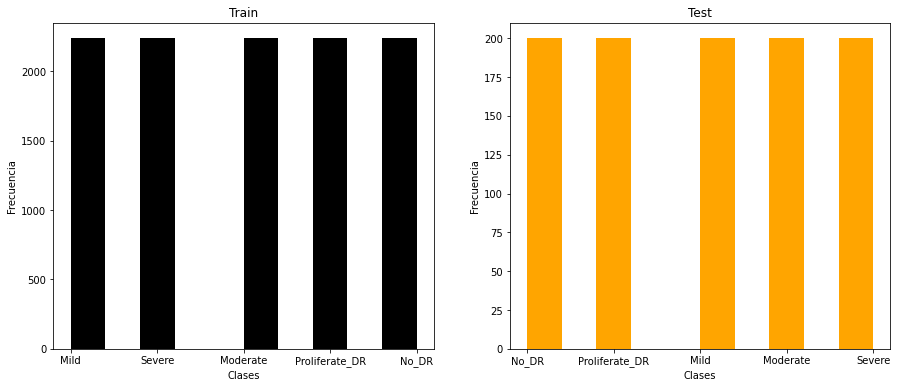

In [ ]:
#@title balance de los datos en train y test
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)
ax.hist(dataset_train.level,color="black");
ax.set_xlabel('Clases');
ax.set_ylabel('Frecuencia');
ax.set_title('Train');
ax = fig.add_subplot(1, 2, 2)
ax.hist(dataset_test.level,color="orange");
ax.set_xlabel('Clases');
ax.set_ylabel('Frecuencia');
ax.set_title('Test');

In [11]:
len(os.listdir('/content/drive/My Drive/IAII/resize/train2/Moderate'))

1849

In [14]:
len(os.listdir('/content/drive/My Drive/IAII/resize/test/No_DR'))

800

In [10]:
noDr = os.listdir('/content/drive/My Drive/IAII/resize/train2/No_DR')[:800]
np.random.shuffle(noDr)

np.save('numpy/noDr3',np.array(noDr))
ruta = os.getcwd() + os.sep
#No_DR
for i in noDr:
  origen = ruta + 'resize/train2/No_DR/' + i
  destino = ruta + 'resize/test/No_DR/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')

In [ ]:
moderate = os.listdir('/content/drive/My Drive/IAII/resize/train2/Moderate')[:500]
noDr = os.listdir('/content/drive/My Drive/IAII/resize/train2/No_DR')[:500]

np.save('numpy/moderate2',np.array(moderate))
np.save('numpy/noDr2',np.array(noDr))

ruta = os.getcwd() + os.sep
#Moderate
for i in moderate:
  origen = ruta + 'resize/train2/Moderate/' + i
  destino = ruta + 'resize/train/Moderate/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')

#No_DR
for i in noDr:
  origen = ruta + 'resize/train2/No_DR/' + i
  destino = ruta + 'resize/train/No_DR/' + i
  if os.path.exists(origen):
    shutil.move(origen, destino)
  else:
    print('El archivo origen no existe')

In [15]:
#@title create train y test generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

testdatagen = tf.keras.preprocessing.image.ImageDataGenerator()

#creamos el test generator
test_generator = testdatagen.flow_from_directory(
    'resize/test',
    target_size=(128,128),
    color_mode='rgb',
    classes=['No_DR','Mild','Moderate','Severe','Proliferate_DR'],
    class_mode='categorical',
    batch_size=128,
    shuffle=True
)

#creamos el train generator
train_generator = datagen.flow_from_directory(
    'resize/train',
    target_size=(128,128),
    color_mode='rgb',
    classes=['No_DR','Mild','Moderate','Severe','Proliferate_DR'],
    class_mode='categorical',
    batch_size=128,
    shuffle=True
)

train_generator.class_indices = {'No_DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferate_DR': 4}
test_generator.class_indices = {'No_DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferate_DR': 4}

Found 1600 images belonging to 5 classes.
Found 13190 images belonging to 5 classes.


In [ ]:
train_generator.class_indices

{'Mild': 1, 'Moderate': 2, 'No_DR': 0, 'Proliferate_DR': 4, 'Severe': 3}

In [ ]:
test_generator.class_indices

{'Mild': 1, 'Moderate': 2, 'No_DR': 0, 'Proliferate_DR': 4, 'Severe': 3}

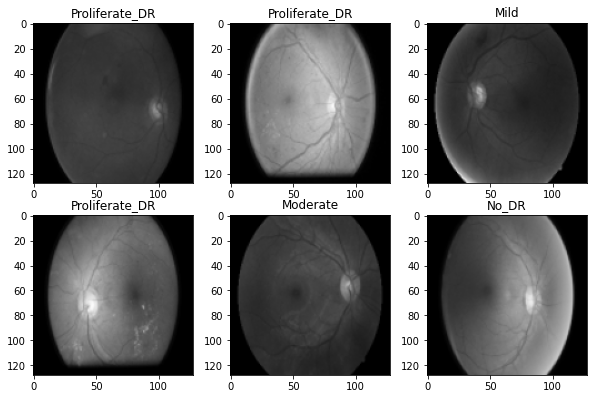

In [ ]:
#@title Visualización imágenes de test
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
plt.figure(figsize=(10,10));
plt.xticks([]);
plt.yticks([]);
plt.grid(False);
for X_batch, y_batch in test_generator:
    for i in range(6):
      plt.subplot(330 + 1 + i)
      plt.imshow(X_batch[i].astype('uint8'), vmin=0, vmax=255);
      plt.title(class_labels[np.argmax(y_batch[i])])
    plt.show()
    break

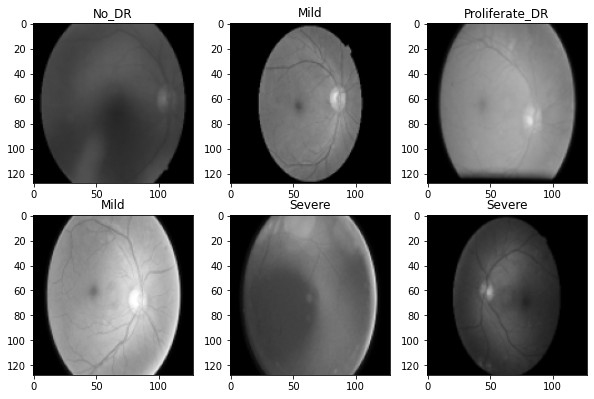

In [ ]:
#@title Visualización imágenes de train
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
plt.figure(figsize=(10,10));
plt.xticks([]);
plt.yticks([]);
plt.grid(False);
for X_batch, y_batch in train_generator:
    for i in range(6):
      plt.subplot(330 + 1 + i)
      plt.imshow(X_batch[i].astype('uint8'), vmin=0, vmax=255);
      plt.title(class_labels[np.argmax(y_batch[i])])
    plt.show()
    break

In [17]:
#@title función para generar la gráfica de entrenamiento
def plotGraficas(history):
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(1, 3, 1)
  ax.plot(history.history['accuracy'], label='Train Accuracy');
  ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
  ax.set_xlabel('Epochs');
  ax.set_ylabel('Accuracy');
  ax.legend();
  ax = fig.add_subplot(1, 3, 2)
  ax.plot(history.history['f1_score'], label='train f1 score');
  ax.plot(history.history['val_f1_score'], label='evaluation f1 score');
  ax.legend();
  ax.set_xlabel('Epochs');
  ax.set_ylabel('score');
  ax = fig.add_subplot(1, 3, 3)
  ax.plot(history.history['loss'], label='train loss');
  ax.plot(history.history['val_loss'], label='evaluation loss');
  ax.legend();
  ax.set_xlabel('Epochs');
  ax.set_ylabel('loss');

In [18]:
#@title Callbacks list
#Devolución de llamada para guardar el modelo Keras o los pesos del modelo con cierta frecuencia. 
checkpoint_path = 'save_model/checkpointXception.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_f1_score',
    mode='max',
    verbose=1, 
    save_best_only=True)

#Detenga el entrenamiento cuando una métrica monitoreada haya dejado de mejorar. 
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score', 
    mode='max',
    patience=20)


#Reducir la tasa de aprendizaje cuando una métrica ha dejado de mejorar. 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1_score', 
    factor=0.5, 
    patience=4, 
    verbose=1, 
    mode='max', 
    cooldown=4, 
    min_lr=0.0000001)

callbacks_list = [early, reduce_lr,checkpoint]

In [16]:
#@title Matriz de confusión
from sklearn.metrics import * 
import seaborn as sns
def matriz_confusion(ytest, ypredict):
    target= [0,1,2,3,4]
    conf_matrix = confusion_matrix(ytest, ypredict)
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, xticklabels=target, yticklabels=target, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')
    plt.show()
    print (classification_report(ytest, ypredict))
    return None

##VGG16

In [ ]:
#@title Creacion de las capas para agregar
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
m_flatten = tf.keras.layers.Flatten(name = "flatten")
m_dense1 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.5)
m_dense2 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.3)
prediction_layer = tf.keras.layers.Dense(5, activation = "softmax")

In [ ]:
#@title Modelo VGG16
Xc_model = tf.keras.applications.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (128, 128, 3))


model_on_Xc = tf.keras.Sequential([
  Xc_model,
  global_average_layer,
  m_flatten,
  m_dense1,
  m_dropout1,
  m_dense2,
  m_dropout1,
  prediction_layer
])

print(model_on_Xc.summary())

print("number of layers to train: ", len(model_on_Xc.trainable_variables))

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_______________________________________________________

In [ ]:
model_on_Xc.load_weights(checkpoint_path)
#model_on_Xc.save('save_model/MobileNetV2')
#model_on_Xc = tf.keras.models.load_model('save_model/Xception')

In [ ]:
#@title Primer entrenamiento
import tensorflow_addons as tfa
learning_rate= 0.001
opt = tf.keras.optimizers.Adam(lr=learning_rate)
model_on_Xc.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])

history = model_on_Xc.fit(train_generator,
                       epochs=50,
                       validation_data=test_generator,
                       callbacks=callbacks_list)

In [ ]:
model_on_Xc.load_weights(checkpoint_path)

Fine tunning

In [ ]:
#Xc_model.trainable = True
#print("Total layers of VGG16: ", len(Xc_model.layers))
#for layer in Xc_model.layers[:9]:
#  layer.trainable =  False
#model_on_Xc.summary()
#print("Total non trainable layers of Model : ", len(model_on_Xc.non_trainable_variables))
#print("Total trainable layers of Model : ",len(model_on_Xc.trainable_variables))

In [ ]:
model_on_Xc.load_weights(checkpoint_path)

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_on_Xc.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_on_Xc.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])
history3 = model_on_Xc.fit(train_generator,
                       epochs=2,
                       validation_data=test_generator,
                       callbacks=callbacks_list)

Epoch 1/2
88/88 [==============================] - 52s 573ms/step - loss: 0.7657 - accuracy: 0.8642 - f1_score: 0.8630 - val_loss: 2.0759 - val_accuracy: 0.5940 - val_f1_score: 0.6076

Epoch 00001: val_f1_score did not improve from 0.63010
Epoch 2/2
88/88 [==============================] - 48s 547ms/step - loss: 0.0114 - accuracy: 0.9979 - f1_score: 0.9979 - val_loss: 2.5350 - val_accuracy: 0.5990 - val_f1_score: 0.6112

Epoch 00002: val_f1_score did not improve from 0.63010


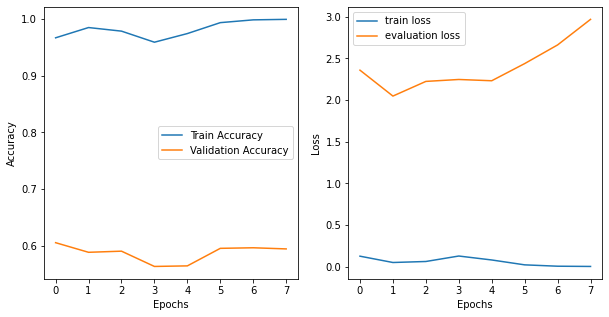

In [ ]:
#@title gráfica del cuarto entrenamiento de la Xception 
plotGraficas(history4)

In [ ]:
#model_on_Xc = tf.keras.models.load_model('save_model/Xception')

In [ ]:
model_on_Xc.evaluate(train_generator)

88/88 [==============================] - 21s 237ms/step - loss: 4.7279e-05 - accuracy: 1.0000 - f1_score: 1.0000


[4.7278805141104385e-05, 1.0, 1.0]

In [ ]:
model_on_Xc.evaluate(test_generator)

8/8 [==============================] - 15s 1s/step - loss: 3.8551 - accuracy: 0.6008 - f1_score: 0.6205


[3.894253969192505, 0.6119999885559082, 0.630098283290863]

In [25]:
#@title X_test Y_test
y_test = []
x_test = []
j = 0
for X_batch, y_batch in test_generator:
  for i in range(len(X_batch)):
    x_test.append(X_batch[i])
    y_test.append(y_batch[i])
  j=j+1
  if j==13:
    break
x_test = np.array(x_test)
y_test = np.argmax(y_test, axis=1)

np.save('numpy/x_test2',x_test)
np.save('numpy/y_test2',y_test)

x_test = np.load('numpy/x_test2.npy')
y_test = np.load('numpy/y_test2.npy')

In [ ]:
Y_pred = model_on_Xc.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

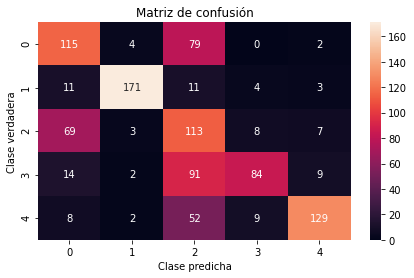

              precision    recall  f1-score   support

           0       0.53      0.57      0.55       200
           1       0.94      0.85      0.90       200
           2       0.33      0.56      0.41       200
           3       0.80      0.42      0.55       200
           4       0.86      0.65      0.74       200

    accuracy                           0.61      1000
   macro avg       0.69      0.61      0.63      1000
weighted avg       0.69      0.61      0.63      1000



In [ ]:
matriz_confusion(y_test,y_pred)

In [ ]:
#@title X_train Y_train
#x_train = []
#y_train = []
#j = 0
#for X_batch, y_batch in train_generator:
#  for i in range(len(X_batch)):
#    x_train.append(X_batch[i])
#    y_train.append(y_batch[i])
#  j=j+1
#  if j==88:
#    break
#x_train = np.array(x_train)
#y_train = np.argmax(y_train, axis=1)

#np.save('numpy/x_train',x_train)
#np.save('numpy/y_train',y_train)

x_train = np.load('numpy/x_train.npy')
y_train = np.load('numpy/y_train.npy')

In [ ]:
Y_pred = model_on_Xc.predict(x_train)
y_pred = np.argmax(Y_pred, axis=1)

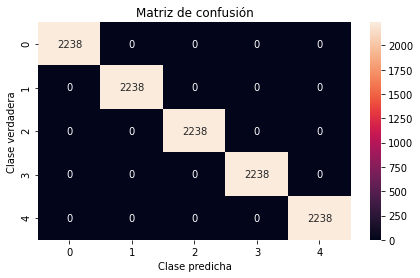

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2238
           1       1.00      1.00      1.00      2238
           2       1.00      1.00      1.00      2238
           3       1.00      1.00      1.00      2238
           4       1.00      1.00      1.00      2238

    accuracy                           1.00     11190
   macro avg       1.00      1.00      1.00     11190
weighted avg       1.00      1.00      1.00     11190



In [ ]:
matriz_confusion(y_train,y_pred)

In [ ]:
pred_Y = model_on_Xc.predict(x_test)

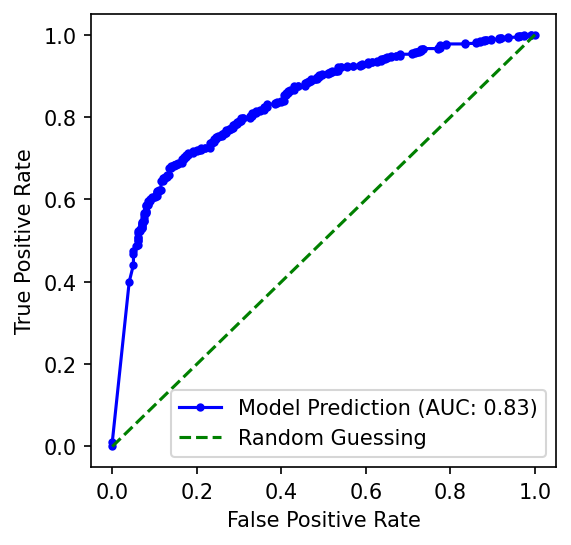

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = y_test>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, thresholds  = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing',linestyle='--')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

##Xception

In [19]:
#@title Creacion de las capas para agregar
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
m_flatten = tf.keras.layers.Flatten(name = "flatten")
m_dense1 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.5)
m_dense2 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.3)
prediction_layer = tf.keras.layers.Dense(5, activation = "softmax")

In [20]:
#@title model xception
Xc_model1 = tf.keras.applications.Xception(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (128, 128, 3))



model_on_Xc1 = tf.keras.Sequential([
  Xc_model1,
  global_average_layer,
  m_flatten,
  m_dense1,
  m_dropout1,
  m_dense2,
  m_dropout1,
  prediction_layer
])

print(model_on_Xc1.summary())
print("number of layers to train: ", len(model_on_Xc1.trainable_variables))

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________

In [21]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_on_Xc1.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_on_Xc1.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])
history3 = model_on_Xc1.fit(train_generator,
                       epochs=100,
                       validation_data=test_generator,
                       callbacks=callbacks_list)

Epoch 1/100
104/104 [==============================] - 101s 930ms/step - loss: 0.0268 - accuracy: 0.9910 - f1_score: 0.9912 - val_loss: 2.4349 - val_accuracy: 0.6050 - val_f1_score: 0.6342

Epoch 00001: val_f1_score did not improve from 0.64016
Epoch 2/100
104/104 [==============================] - 97s 934ms/step - loss: 0.0353 - accuracy: 0.9892 - f1_score: 0.9878 - val_loss: 2.2538 - val_accuracy: 0.6260 - val_f1_score: 0.6378

Epoch 00002: val_f1_score did not improve from 0.64016
Epoch 3/100
104/104 [==============================] - 97s 934ms/step - loss: 0.0132 - accuracy: 0.9959 - f1_score: 0.9961 - val_loss: 2.8498 - val_accuracy: 0.5720 - val_f1_score: 0.5941

Epoch 00003: val_f1_score did not improve from 0.64016
Epoch 4/100
104/104 [==============================] - 97s 935ms/step - loss: 0.0171 - accuracy: 0.9950 - f1_score: 0.9950 - val_loss: 1.8200 - val_accuracy: 0.6320 - val_f1_score: 0.6516

Epoch 00004: val_f1_score improved from 0.64016 to 0.65155, saving model to sa

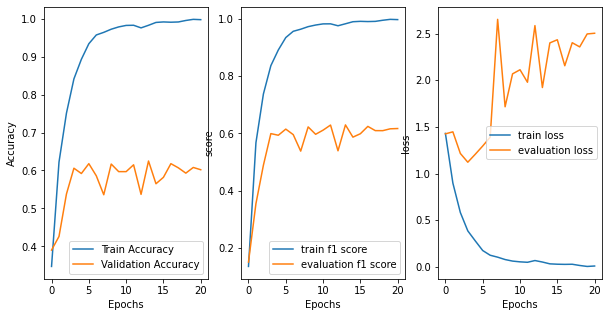

In [ ]:
plotGraficas(history3)

In [44]:
checkpoint_path = 'save_model/checkpointXception2.h5'

In [45]:
model_on_Xc1.load_weights(checkpoint_path)

In [ ]:
model_on_Xc1.evaluate(train_generator)

88/88 [==============================] - 21s 238ms/step - loss: 0.0013 - accuracy: 0.9996 - f1_score: 0.9996


[0.0013043596409261227, 0.999642550945282, 0.999642550945282]

In [46]:
model_on_Xc1.evaluate(test_generator)

13/13 [==============================] - 3s 219ms/step - loss: 2.0705 - accuracy: 0.6825 - f1_score: 0.7003


[2.070528030395508, 0.6825000047683716, 0.7003463506698608]

In [47]:
Y_pred = model_on_Xc1.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

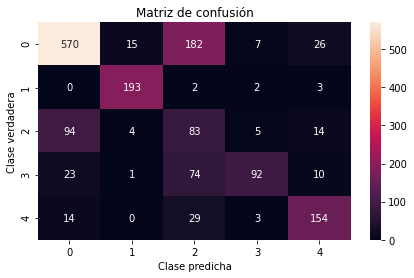

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       800
           1       0.91      0.96      0.93       200
           2       0.22      0.41      0.29       200
           3       0.84      0.46      0.60       200
           4       0.74      0.77      0.76       200

    accuracy                           0.68      1600
   macro avg       0.71      0.66      0.67      1600
weighted avg       0.75      0.68      0.70      1600



In [48]:
matriz_confusion(y_test,y_pred)

In [ ]:
Y_pred = model_on_Xc1.predict(x_train)
y_pred = np.argmax(Y_pred, axis=1)

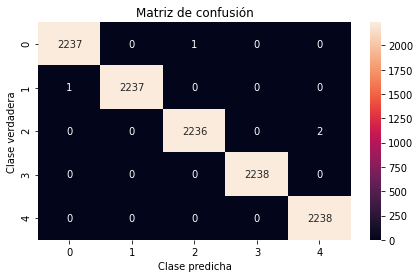

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2238
           1       1.00      1.00      1.00      2238
           2       1.00      1.00      1.00      2238
           3       1.00      1.00      1.00      2238
           4       1.00      1.00      1.00      2238

    accuracy                           1.00     11190
   macro avg       1.00      1.00      1.00     11190
weighted avg       1.00      1.00      1.00     11190



In [ ]:
matriz_confusion(y_train,y_pred)

In [49]:
pred_Y = model_on_Xc1.predict(x_test)

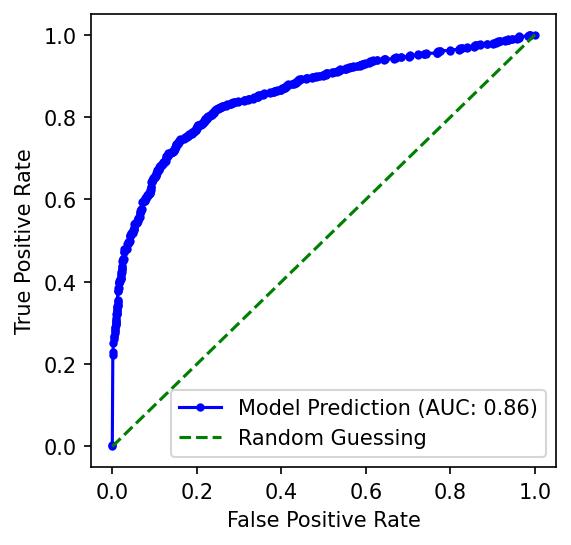

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = y_test>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, thresholds  = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing',linestyle='--')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

In [51]:
binary_test = y_test>0
binary_predic = y_pred>0

In [ ]:
np.unique(binary_predic)

array([False,  True])

In [ ]:
np.unique(binary_test)

array([False,  True])

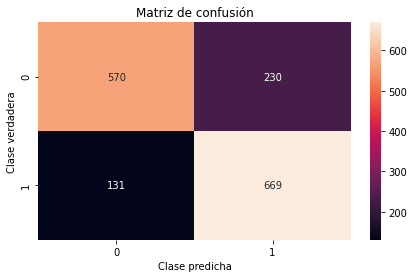

              precision    recall  f1-score   support

       False       0.81      0.71      0.76       800
        True       0.74      0.84      0.79       800

    accuracy                           0.77      1600
   macro avg       0.78      0.77      0.77      1600
weighted avg       0.78      0.77      0.77      1600



In [52]:
conf_matrix = confusion_matrix(binary_test, binary_predic)
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, xticklabels=[0,1], yticklabels=[0,1], annot=True, fmt="d");
plt.title("Matriz de confusión")
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()
print (classification_report(binary_test, binary_predic))

##InceptionResNetV2

In [ ]:
#@title Creacion de las capas para agregar
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
m_flatten = tf.keras.layers.Flatten(name = "flatten")
m_dense1 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.5)
m_dense2 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.3)
prediction_layer = tf.keras.layers.Dense(5, activation = "softmax")

In [ ]:
#@title model InceptionResNetV2
Xc_model2 = tf.keras.applications.InceptionResNetV2(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (128, 128, 3))



model_on_Xc2 = tf.keras.Sequential([
  Xc_model2,
  global_average_layer,
  m_flatten,
  m_dense1,
  m_dropout1,
  m_dense2,
  m_dropout1,
  prediction_layer
])

print(model_on_Xc2.summary())
print("number of layers to train: ", len(model_on_Xc2.trainable_variables))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_on_Xc2.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_on_Xc2.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])
history3 = model_on_Xc2.fit(train_generator,
                       epochs=100,
                       validation_data=test_generator,
                       callbacks=callbacks_list)

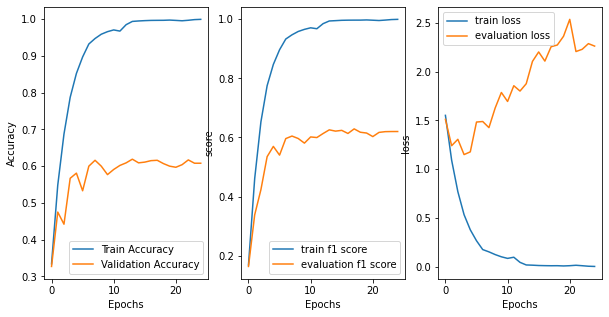

In [ ]:
plotGraficas(history3)

In [ ]:
model_on_Xc2.load_weights(checkpoint_path)

In [ ]:
model_on_Xc2.evaluate(train_generator)

88/88 [==============================] - 22s 243ms/step - loss: 0.0037 - accuracy: 0.9991 - f1_score: 0.9992


[0.003733578836545348, 0.9991063475608826, 0.999151349067688]

In [ ]:
model_on_Xc2.evaluate(test_generator)

8/8 [==============================] - 2s 235ms/step - loss: 2.2547 - accuracy: 0.6160 - f1_score: 0.6289


[2.2546579837799072, 0.6159999966621399, 0.6289455890655518]

In [ ]:
Y_pred = model_on_Xc2.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

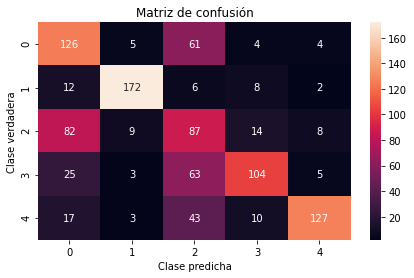

              precision    recall  f1-score   support

           0       0.48      0.63      0.55       200
           1       0.90      0.86      0.88       200
           2       0.33      0.43      0.38       200
           3       0.74      0.52      0.61       200
           4       0.87      0.64      0.73       200

    accuracy                           0.62      1000
   macro avg       0.66      0.62      0.63      1000
weighted avg       0.66      0.62      0.63      1000



In [ ]:
matriz_confusion(y_test,y_pred)

In [ ]:
Y_pred = model_on_Xc2.predict(x_train)
y_pred = np.argmax(Y_pred, axis=1)

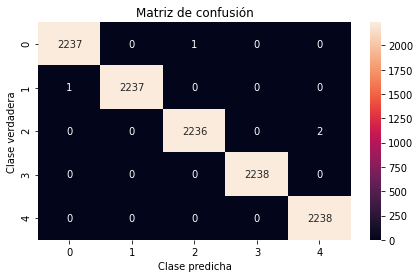

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2238
           1       1.00      1.00      1.00      2238
           2       1.00      1.00      1.00      2238
           3       1.00      1.00      1.00      2238
           4       1.00      1.00      1.00      2238

    accuracy                           1.00     11190
   macro avg       1.00      1.00      1.00     11190
weighted avg       1.00      1.00      1.00     11190



In [ ]:
matriz_confusion(y_train,y_pred)

In [ ]:
pred_Y = model_on_Xc2.predict(x_test)

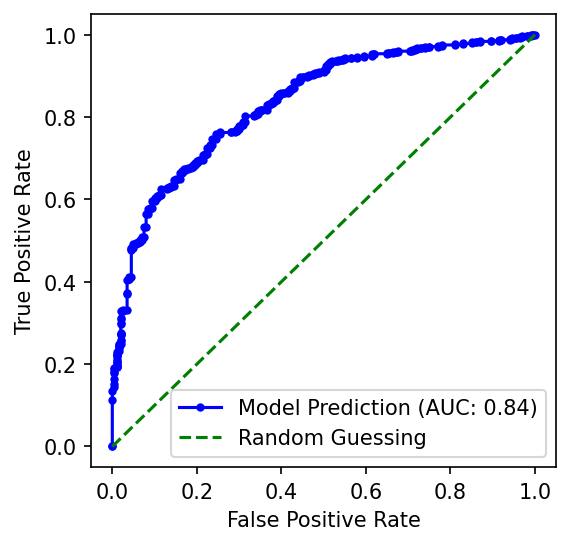

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = y_test>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, thresholds  = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing',linestyle='--')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

##prueba

In [ ]:
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
m_flatten = tf.keras.layers.Flatten(name = "flatten")
m_dense1 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.5)
m_dense2 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.3)
prediction_layer = tf.keras.layers.Dense(5, activation = "softmax")

In [ ]:
Xc_model0 = tf.keras.applications.InceptionResNetV2(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (128, 128, 3))

model_on_Xc0 = tf.keras.Sequential([
  Xc_model0,
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Flatten(name = "flatten"),
  tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(5, activation = "softmax")
])

print(model_on_Xc0.summary())
print("number of layers to train: ", len(model_on_Xc0.trainable_variables))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_max_pooling2d_12 (Glo (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               393472    
_________________________________________________________________
batch_normalization_1837 (Ba (None, 256)               1024      
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)             

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_on_Xc0.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=[tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])
history3 = model_on_Xc0.fit(train_generator,
                       epochs=100,
                       validation_data=test_generator,
                       callbacks=callbacks_list)

Epoch 1/100
88/88 [==============================] - 80s 730ms/step - loss: 1.9420 - f1_score: 0.2587 - val_loss: 1.4573 - val_f1_score: 0.1662

Epoch 00001: val_f1_score improved from 0.00000 to 0.16619, saving model to save_model/checkpointVGG16.h5
Epoch 2/100
88/88 [==============================] - 63s 708ms/step - loss: 1.3925 - f1_score: 0.4178 - val_loss: 1.3005 - val_f1_score: 0.3546

Epoch 00002: val_f1_score improved from 0.16619 to 0.35464, saving model to save_model/checkpointVGG16.h5
Epoch 3/100
88/88 [==============================] - 63s 712ms/step - loss: 1.0102 - f1_score: 0.5803 - val_loss: 1.7172 - val_f1_score: 0.2624

Epoch 00003: val_f1_score did not improve from 0.35464
Epoch 4/100
88/88 [==============================] - 63s 718ms/step - loss: 0.7817 - f1_score: 0.6761 - val_loss: 1.2237 - val_f1_score: 0.4837

Epoch 00004: val_f1_score improved from 0.35464 to 0.48371, saving model to save_model/checkpointVGG16.h5
Epoch 5/100
88/88 [============================

In [ ]:
model_on_Xc0.load_weights(checkpoint_path)

In [ ]:
model_on_Xc0.evaluate(train_generator)

88/88 [==============================] - 22s 252ms/step - loss: 0.0181 - f1_score: 0.9953


[0.018122605979442596, 0.9952556490898132]

In [ ]:
model_on_Xc0.evaluate(test_generator)

8/8 [==============================] - 2s 240ms/step - loss: 1.6650 - f1_score: 0.6182


[1.6650243997573853, 0.6181920766830444]

In [ ]:
Y_pred = model_on_Xc0.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

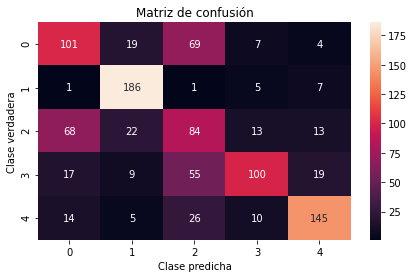

              precision    recall  f1-score   support

           0       0.50      0.51      0.50       200
           1       0.77      0.93      0.84       200
           2       0.36      0.42      0.39       200
           3       0.74      0.50      0.60       200
           4       0.77      0.72      0.75       200

    accuracy                           0.62      1000
   macro avg       0.63      0.62      0.62      1000
weighted avg       0.63      0.62      0.62      1000



In [ ]:
matriz_confusion(y_test,y_pred)

In [ ]:
Y_pred = model_on_Xc0.predict(x_train)
y_pred = np.argmax(Y_pred, axis=1)

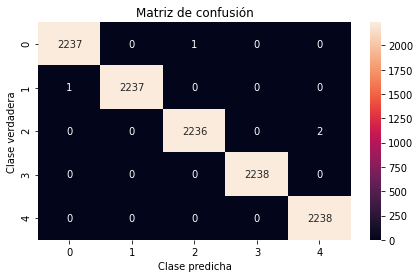

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2238
           1       1.00      1.00      1.00      2238
           2       1.00      1.00      1.00      2238
           3       1.00      1.00      1.00      2238
           4       1.00      1.00      1.00      2238

    accuracy                           1.00     11190
   macro avg       1.00      1.00      1.00     11190
weighted avg       1.00      1.00      1.00     11190



In [ ]:
matriz_confusion(y_train,y_pred)

In [ ]:
pred_Y = model_on_Xc0.predict(x_test)

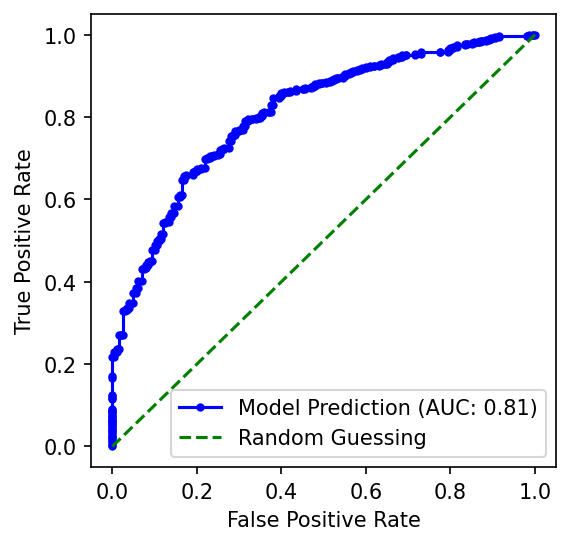

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = y_test>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, thresholds  = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing',linestyle='--')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

##MobileNetV2

In [ ]:
#@title Creacion de las capas para agregar
global_average_layer = tf.keras.layers.GlobalMaxPooling2D()
m_flatten = tf.keras.layers.Flatten(name = "flatten")
m_dense1 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.5)
m_dense2 = tf.keras.layers.Dense(256, activation = "relu", kernel_initializer='he_uniform', bias_initializer='he_uniform')
m_dropout1 = tf.keras.layers.Dropout(0.3)
prediction_layer = tf.keras.layers.Dense(5, activation = "softmax")

In [ ]:
#@title model MobileNetV2
Xc_model3 = tf.keras.applications.MobileNetV2(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (128, 128, 3))



model_on_Xc3 = tf.keras.Sequential([
  Xc_model3,
  global_average_layer,
  m_flatten,
  m_dense1,
  m_dropout1,
  m_dense2,
  m_dropout1,
  prediction_layer
])

print(model_on_Xc3.summary())
print("number of layers to train: ", len(model_on_Xc3.trainable_variables))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_on_Xc3.compile(optimizer=opt, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy', tfa.metrics.F1Score(num_classes=5, threshold=0.5,average='weighted')])
history3 = model_on_Xc3.fit(train_generator,
                       epochs=5,
                       validation_data=test_generator,
                       callbacks=callbacks_list)

Epoch 1/5
88/88 [==============================] - 29s 286ms/step - loss: 0.0640 - accuracy: 0.9786 - f1_score: 0.9783 - val_loss: 2.1213 - val_accuracy: 0.5710 - val_f1_score: 0.5626

Epoch 00001: val_f1_score did not improve from 0.59959
Epoch 2/5
88/88 [==============================] - 25s 279ms/step - loss: 0.0839 - accuracy: 0.9697 - f1_score: 0.9698 - val_loss: 2.5341 - val_accuracy: 0.5400 - val_f1_score: 0.5431

Epoch 00002: val_f1_score did not improve from 0.59959
Epoch 3/5
88/88 [==============================] - 25s 281ms/step - loss: 0.1037 - accuracy: 0.9631 - f1_score: 0.9638 - val_loss: 2.2434 - val_accuracy: 0.5380 - val_f1_score: 0.5300

Epoch 00003: val_f1_score did not improve from 0.59959
Epoch 4/5
88/88 [==============================] - 25s 282ms/step - loss: 0.0870 - accuracy: 0.9704 - f1_score: 0.9706 - val_loss: 2.3536 - val_accuracy: 0.5690 - val_f1_score: 0.5617

Epoch 00004: val_f1_score did not improve from 0.59959
Epoch 5/5
88/88 [=======================

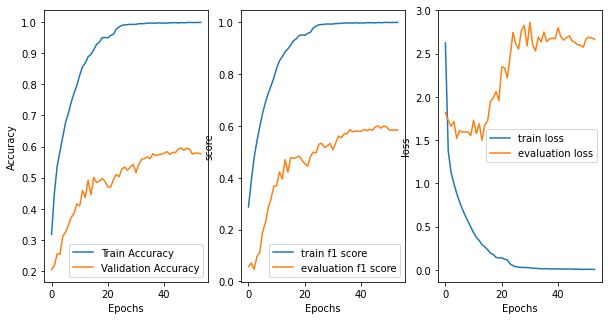

In [ ]:
plotGraficas(history3)

In [ ]:
model_on_Xc3.load_weights(checkpoint_path)

In [ ]:
model_on_Xc3.evaluate(train_generator)

88/88 [==============================] - 19s 217ms/step - loss: 3.6211e-04 - accuracy: 1.0000 - f1_score: 1.0000


[0.00036211084807291627, 1.0, 1.0]

In [ ]:
model_on_Xc3.evaluate(test_generator)

8/8 [==============================] - 2s 215ms/step - loss: 2.6298 - accuracy: 0.5960 - f1_score: 0.5996


[2.6298298835754395, 0.5960000157356262, 0.5995899438858032]

In [ ]:
Y_pred = model_on_Xc3.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

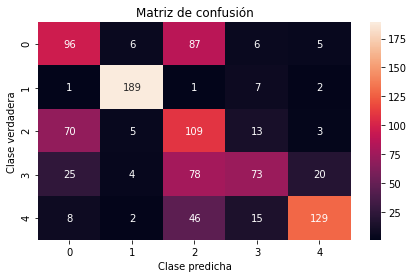

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       200
           1       0.92      0.94      0.93       200
           2       0.34      0.55      0.42       200
           3       0.64      0.36      0.46       200
           4       0.81      0.65      0.72       200

    accuracy                           0.60      1000
   macro avg       0.64      0.60      0.60      1000
weighted avg       0.64      0.60      0.60      1000



In [ ]:
matriz_confusion(y_test,y_pred)

In [ ]:
Y_pred = model_on_Xc3.predict(x_train)
y_pred = np.argmax(Y_pred, axis=1)

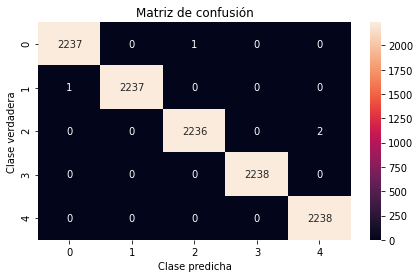

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2238
           1       1.00      1.00      1.00      2238
           2       1.00      1.00      1.00      2238
           3       1.00      1.00      1.00      2238
           4       1.00      1.00      1.00      2238

    accuracy                           1.00     11190
   macro avg       1.00      1.00      1.00     11190
weighted avg       1.00      1.00      1.00     11190



In [ ]:
matriz_confusion(y_train,y_pred)


Curva ROC para sanos vs enfermos

Aquí hacemos una curva ROC para sanos ( severity == 0) y enfermos ( severity>0) para ver qué tan bien funciona el modelo al identificar la enfermedad.


In [ ]:
pred_Y = model_on_Xc3.predict(x_test)

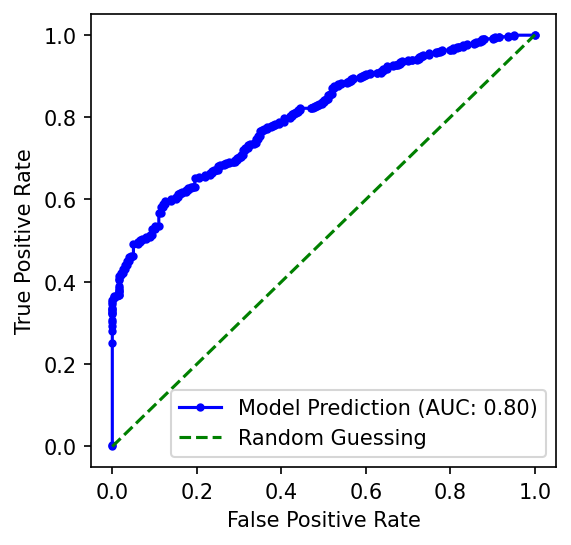

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = y_test>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, thresholds  = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing',linestyle='--')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');